# Prueba phi-3-vision

In [ ]:
!pip install numpy==1.24.4 Pillow==10.3.0 Requests==2.31.0 torch==2.3.0 torchvision==0.18.0 transformers==4.40.2 osmnx --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 78.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 107.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 111.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 74.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imageio 2.31.6 requires pillow<10.1.0,>=8.3.2, but you have pillow 10.3.0 which is incompatible.
pandas-stubs 2.0.3.230814 requires numpy

In [ ]:
!pip install accelerate --quiet

In [ ]:
from google.colab import files
from PIL import Image
import IPython.display as display
import requests
from transformers import AutoModelForCausalLM
from transformers import AutoProcessor
import torch
import gdown
import pandas as pd
import json
import zipfile
import cv2
import matplotlib.pyplot as plt

In [ ]:
import gdown

# Cargar Imagenes
# ID del archivo de Google Drive
from google.colab import userdata
file_id = userdata.get('CIUDADES')
# URL de descarga directa
url = f'https://drive.google.com/uc?id={file_id}'
# Nombre del archivo que deseas guardar
output = 'imagenes_stgo.zip'

gdown.download(url, output, quiet=False, fuzzy=True)
dir_rar = "/content/imagenes_stgo.zip"
# Cargar nodos
df_nodos = pd.read_csv("nodos_final_providencia_total.csv")
df_nodos = df_nodos[pd.notna(df_nodos['nombre_foto'])]
print(len(df_nodos))
df_nodos.head()

# Phi-3-Vision

In [ ]:
model_id = "microsoft/Phi-3-vision-128k-instruct"

model = AutoModelForCausalLM.from_pretrained(model_id,
                                             cache_dir="/content/my_models/phi_3_vision",
                                             device_map="cuda",
                                             trust_remote_code=True,
                                             torch_dtype="auto",
                                             _attn_implementation="eager")
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

In [ ]:
# Extract attr
prompt = """<|user|>\nYou are an AI model specialized in analyzing urban environments. I am providing you with an image of a street obtained from OpenStreetMap. Please analyze the image based on the following criteria and fill out the JSON schema below. Use the descriptions and the provided labels to evaluate each criterion.
Criteria:
Building and Window Condition: Describe the condition of the buildings and windows.
Street Cleanliness and Maintenance: Describe the cleanliness and maintenance of the street.
Signage and Urban Equipment: Describe the state of signage and urban equipment.
Graffiti and Vandalism Presence: Describe the presence of graffiti and signs of vandalism.
Security Measures and Perception: Describe the visible security measures and overall perception of safety.
Labels for Evaluation:

"Very bad"
"Bad"
"Regular"
"Good"
"Very good"
JSON Schema to Fill:
{
  "building_window_condition": {
    "description": "Description of the state of buildings and windows",
    "label": "Your evaluation here"
  },
  "street_cleanliness_maintenance": {
    "description": "Description of street cleanliness and maintenance",
    "label": "Your evaluation here"
  },
  "signage_urban_equipment": {
    "description": "Description of signage and urban equipment",
    "label": "Your evaluation here"
  },
  "graffiti_vandalism_presence": {
    "description": "Description of graffiti and vandalism presence",
    "label": "Your evaluation here"
  },
  "security_measures_perception": {
    "description": "Description of security measures and perception",
    "label": "Your evaluation here"
  }
}
Please analyze the provided image from OpenStreetMap and complete the JSON schema with your observations and evaluations. <|image_1|>\n<|end|>\n<|assistant|>\n

"""

generation_args = {
    "max_new_tokens": 300,
    "temperature": 0.0,
    "do_sample": False,
}

In [ ]:
def generate_inference(row): # Inference function
    page_index = row["nombre_foto"]
    try:
        with zipfile.ZipFile(dir_rar, 'r') as archivo:
            archivo_contents = archivo.namelist()
            if page_index in archivo_contents:
                archivo.extract(page_index)
                print(f"Nombre foto: {page_index}")
            else:
                print("Error: archivo no encontrado en el zip")
    except FileNotFoundError as e:
        print(f"Error: {e}")
        return None

    direccion = f'/content/{page_index}'
    try:
        image = Image.open(direccion)
    except IOError as e:
        print(f"Error al abrir la imagen: {e}")
        return None

    inputs = processor(prompt, [image], return_tensors="pt").to("cuda:0")
    generate_ids = model.generate(**inputs, eos_token_id=processor.tokenizer.eos_token_id, **generation_args)
    generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
    response = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
    row['text'] = response
    return row['text']

In [ ]:
df = df_nodos.iloc[1:76,]
len(df)

In [ ]:
%%time
df['text'] = df.apply(generate_inference, axis=1)
df.to_csv('outputvision.csv')

# Weight

In [ ]:
import pandas as pd
df = pd.read_csv('outputvision_test.csv')
print(len(df))
df.head(5)

In [ ]:
import json

def parse_string_to_json(string):
    try:
        parsed_json = json.loads(string)
        return parsed_json
    except Exception as e:
        start_idx = string.find('{')
        end_idx = string.rfind('}')
        if start_idx != -1 and end_idx != -1 and end_idx > start_idx:
            json_str = string[start_idx:end_idx+1]
            try:
                parsed_json = json.loads(json_str)
                return parsed_json
            except Exception as e:
                pass  # No imprimir aquí
        try:
            if '"building_window_condition"' in string and '"street_cleanliness_maintenance"' in string and '"signage_urban_equipment"' in string and '"graffiti_vandalism_presence"' in string and '"security_measures_perception"' in string:
                json_str = string.replace("'", '"')
                parsed_json = json.loads(json_str)
                return parsed_json
        except Exception as e:
            pass
        print("Failed to parse JSON")
        return None

In [ ]:
df['text'] = df['text'].apply(parse_string_to_json)

In [ ]:
def calculate_security_weight(json_dict):
    label_weights = {
        "Very bad": 1,
        "Bad": 2,
        "Regular": 3,
        "Good": 4,
        "Very good": 5
    }
    try:
        total_weight = 0
        num_labels = 0
        for category, info in json_dict.items():
            label = info.get('label')
            if label in label_weights:
                total_weight += label_weights[label]
                num_labels += 1
        if num_labels > 0:
            return total_weight / num_labels
        else:
            return None
    except Exception as e:
        return None

In [ ]:
df['weight'] = df['text'].apply(lambda x: calculate_security_weight(x))

In [ ]:
df.head(5)

Unnamed: 0     osmid          y          x  street_count  \
0           1    388705 -33.447411 -70.632154             4   
1           2  13876993 -33.441482 -70.625170             3   
2           3  13876995 -33.439819 -70.618300             4   
3           5  13877004 -33.419308 -70.604247             4   
4           6  13877007 -33.431929 -70.595463             3   

                                         nombre_foto          highway  ref  \
0  imagenes_stgo/-33.481379867132866,-70.79805571...  traffic_signals  NaN   
1  imagenes_stgo/-33.44186860567823,-70.625019858...              NaN  NaN   
2      imagenes_stgo/-33.440183032,-70.618072696.jpg              NaN  NaN   
3  imagenes_stgo/-33.419968713286714,-70.60362961...  traffic_signals  NaN   
4  imagenes_stgo/-33.43176078233438,-70.595379706...              NaN  NaN   

                          geometry  \
0  POINT (-70.6321538 -33.4474114)   
1   POINT (-70.6251697 -33.441482)   
2   POINT (-70.6183001 -33.439819)   
3  POINT (-70.6042474 -33.4193081)   
4  POINT (-70.5954627 -33.4319287)   

                                                text  weight  
0  {'building_window_condition': {'description': ...     2.4  
1  {'building_window_condition': {'description': ...     3.0  
2  {'building_window_condition': {'description': ...     3.6  
3  {'building_window_condition': {'description': ...     3.8  
4  {'building_window_condition': {'description': ...     3.4

In [ ]:
# import zipfile
# import pandas as pd
# from PIL import Image

# def extract_images_from_zip(df, zip_path, output_dir):
#     try:
#         with zipfile.ZipFile(zip_path, 'r') as archivo:
#             archivo_contents = archivo.namelist()
#             for index, row in df.iterrows():
#                 page_index = row["nombre_foto"]
#                 if page_index in archivo_contents:
#                     archivo.extract(page_index, path=output_dir)
#                     print(f"Imagen extraída: {page_index}")
#                 else:
#                     print(f"Error: {page_index} no encontrado en el zip")
#     except FileNotFoundError as e:
#         print(f"Error: {e}")
#         return
#     for index, row in df.iterrows():
#         page_index = row["nombre_foto"]
#         direccion = f'{output_dir}/{page_index}'
#         try:
#             image = Image.open(direccion)
#             image.close()  #
#             print(f"Imagen abierta exitosamente: {page_index}")
#         except IOError as e:
#             print(f"Error al abrir la imagen: {page_index}, {e}")

# zip_path = 'imagenes_stgo.zip'
# output_dir = 'imagenes_stgo'

# extract_images_from_zip(df, zip_path, output_dir)


In [ ]:
images_path = "/content/"

imagenes_stgo/-33.437833776223776,-70.60236710714285.jpg


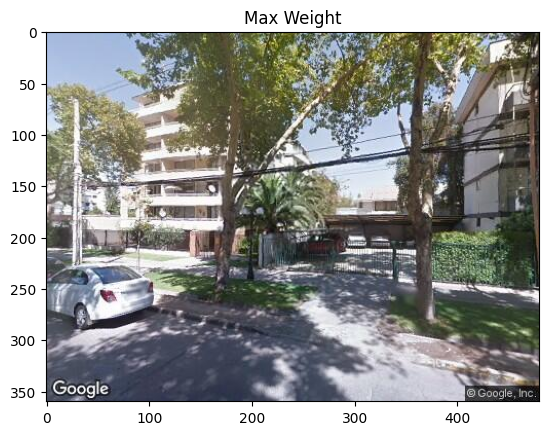

In [ ]:
max_weight_index = df['weight'].idxmax()

nombre_foto_max_weight = df.loc[max_weight_index, 'nombre_foto']
print(nombre_foto_max_weight)

img1 = cv2.imread(f'{images_path}{nombre_foto_max_weight}')
I1 =cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
plt.imshow(I1)
plt.title("Max Weight")
plt.show()

imagenes_stgo/-33.467007423999995,-70.77078556000001.jpg


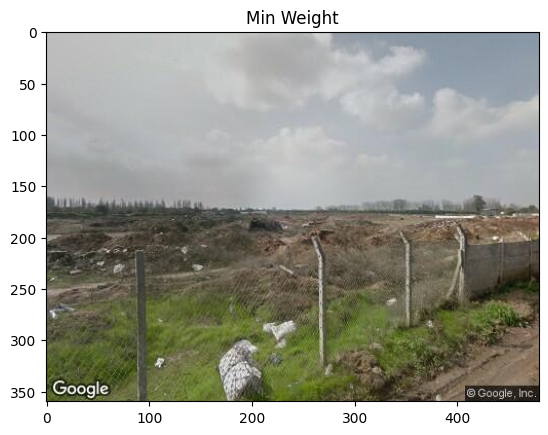

In [ ]:
min_weight_index = df['weight'].idxmin()

nombre_foto_min_weight = df.loc[min_weight_index, 'nombre_foto']

print(nombre_foto_min_weight)

img1 = cv2.imread(f'{images_path}{nombre_foto_min_weight}')
I1 =cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

plt.imshow(I1)
plt.title("Min Weight")

plt.show()

In [ ]:
df.to_csv("prueba_vision_weighted.csv")

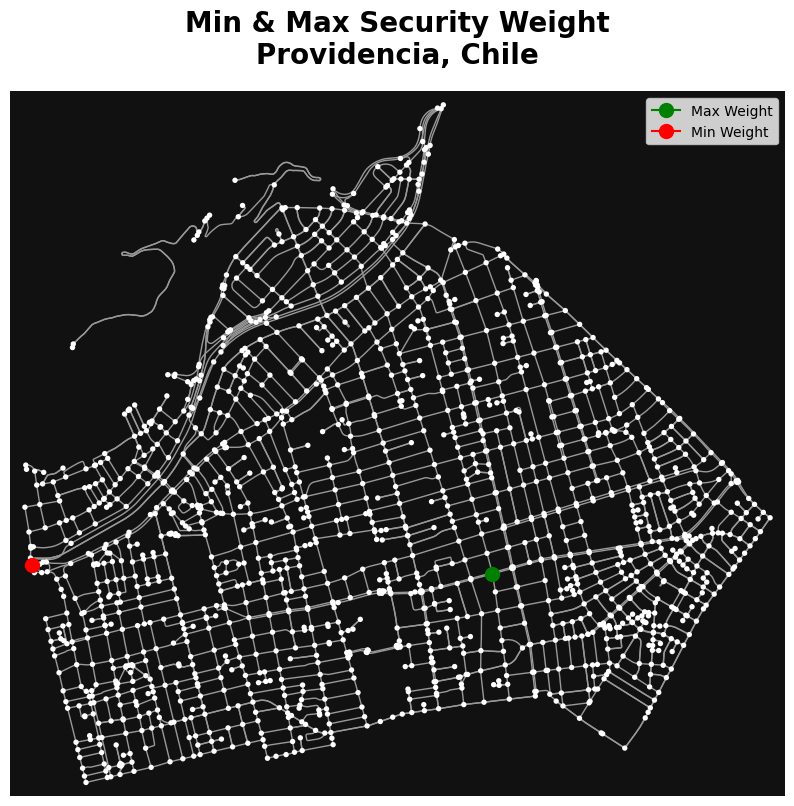

In [ ]:
import osmnx as ox
# Definir el lugar y tipo de red
place = 'Providencia, Chile'
cf = '["highway"~"primary"]'

# Crear el grafo desde el lugar especificado
G = ox.graph_from_place(place, network_type='drive')

# Dibujar el grafo
fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(10,10))

# Encuentra los índices de las filas con el valor máximo y mínimo en la columna 'weight'
max_weight_index = df['weight'].idxmax()
min_weight_index = df['weight'].idxmin()

# Extraer las coordenadas correspondientes al valor máximo y mínimo de 'weight'
max_lon = df.loc[max_weight_index, 'x']
max_lat = df.loc[max_weight_index, 'y']
min_lon = df.loc[min_weight_index, 'x']
min_lat = df.loc[min_weight_index, 'y']

# Dibujar los puntos en el mapa con colores diferentes
ax.set_title("Ubicación en mapa")
ax.plot(max_lon, max_lat, c='green', marker='o', markersize=10, label='Max Weight')
ax.plot(min_lon, min_lat, c='red', marker='o', markersize=10, label='Min Weight')

# Añadir leyenda
ax.legend()

plt.title('Min & Max Security Weight\nProvidencia, Chile', fontsize=20, fontweight='bold', color='black', pad=20)

# Mostrar el gráfico
plt.show()

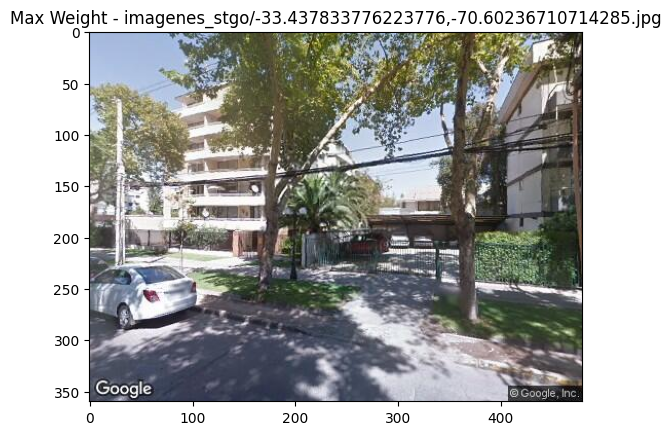

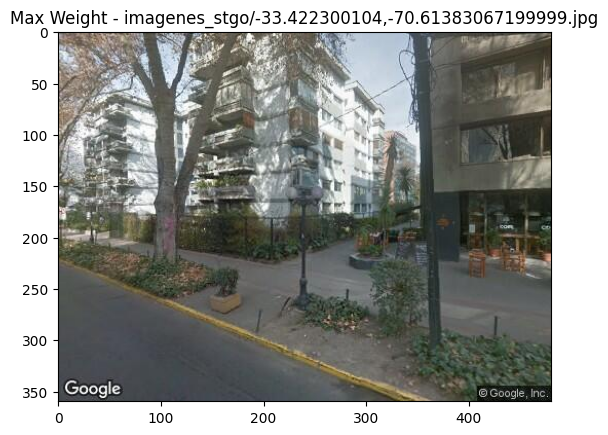

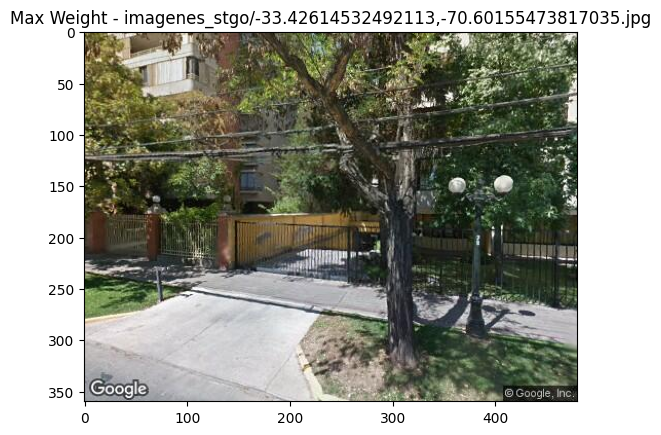

In [ ]:
# Encuentra todas las filas con el valor máximo en la columna 'weight'
max_weight = df['weight'].max()
max_weight_rows = df[df['weight'] == max_weight]
# Mostrar todas las imágenes correspondientes al máximo peso
for idx, row in max_weight_rows.iterrows():
    nombre_foto_max_weight = row['nombre_foto']
    img1 = cv2.imread(f'{images_path}{nombre_foto_max_weight}')
    I1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)  # Formato imread a formato plt

    plt.imshow(I1)
    plt.title(f"Max Weight - {nombre_foto_max_weight}")
    plt.show()

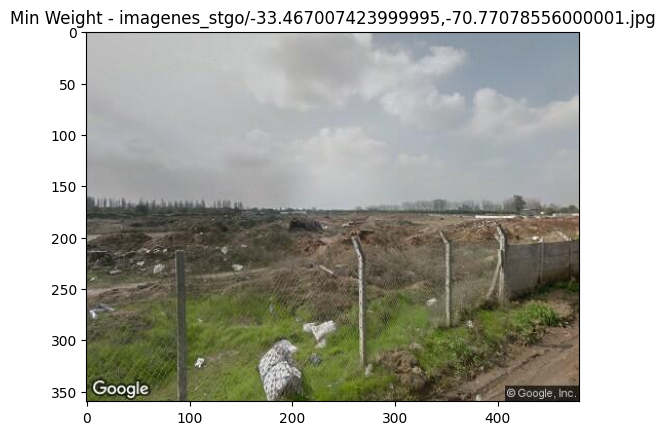

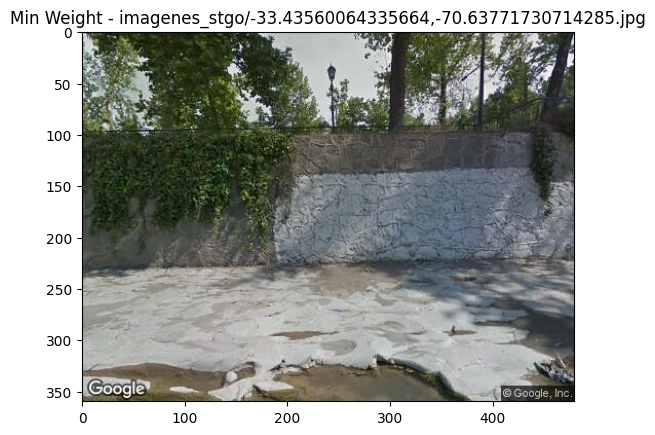

In [ ]:
min_weight = df['weight'].min()
min_weight_rows = df[df['weight'] == min_weight]

# Mostrar todas las imágenes correspondientes al mínimo peso
for idx, row in min_weight_rows.iterrows():
    nombre_foto_min_weight = row['nombre_foto']
    img1 = cv2.imread(f'{images_path}{nombre_foto_min_weight}')
    I1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

    plt.imshow(I1)
    plt.title(f"Min Weight - {nombre_foto_min_weight}")
    plt.show()


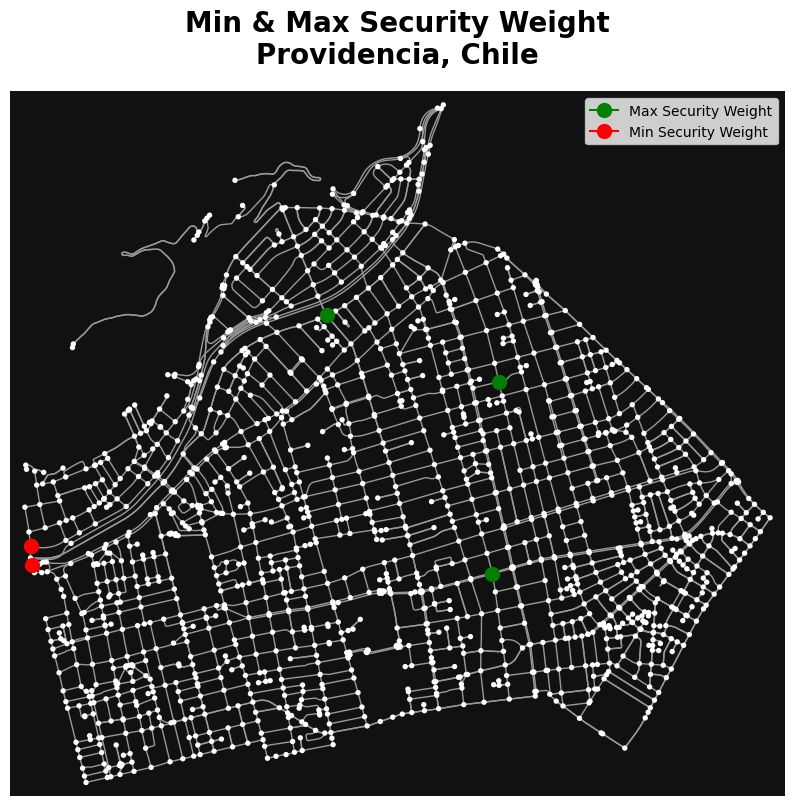

In [ ]:
# Definir el lugar y tipo de red
place = 'Providencia, Chile'
cf = '["highway"~"primary"]'

# Crear el grafo desde el lugar especificado
G = ox.graph_from_place(place, network_type='drive')

# Dibujar el grafo
fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(10, 10))

# Encuentra todas las filas con el valor máximo en la columna 'weight'
max_weight = df['weight'].max()
max_weight_rows = df[df['weight'] == max_weight]

# Encuentra todas las filas con el valor mínimo en la columna 'weight'
min_weight = df['weight'].min()
min_weight_rows = df[df['weight'] == min_weight]

# Dibujar los puntos de máximo peso en el mapa con color verde
for idx, row in max_weight_rows.iterrows():
    ax.plot(row['x'], row['y'], c='green', marker='o', markersize=10, label='Max Security Weight' if idx == max_weight_rows.index[0] else "")

# Dibujar los puntos de mínimo peso en el mapa con color rojo
for idx, row in min_weight_rows.iterrows():
    ax.plot(row['x'], row['y'], c='red', marker='o', markersize=10, label='Min Security Weight' if idx == min_weight_rows.index[0] else "")

# Añadir leyenda
ax.legend()
plt.title('Min & Max Security Weight\nProvidencia, Chile', fontsize=20, fontweight='bold', color='black', pad=20)
# Mostrar el gráfico
plt.show()

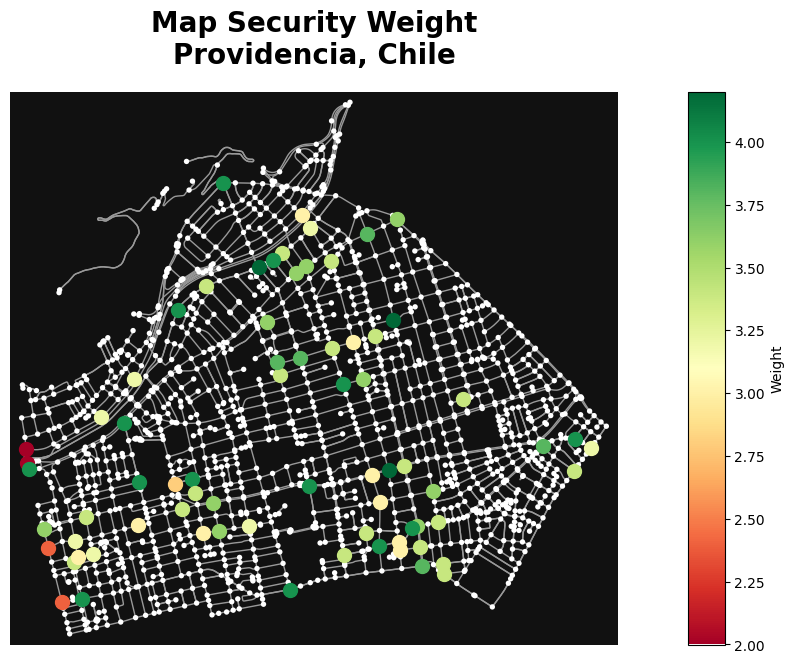

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import osmnx as ox
import numpy as np
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Definir el lugar y tipo de red
place = 'Providencia, Chile'
cf = '["highway"~"primary"]'

# Crear el grafo desde el lugar especificado
G = ox.graph_from_place(place, network_type='drive')

# Dibujar el grafo
fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(10, 10))

# Normalizar los valores de 'weight' para la colormap
norm = Normalize(vmin=df['weight'].min(), vmax=df['weight'].max())
cmap = plt.get_cmap('RdYlGn')  # Usar una colormap de rojo a verde

# Dibujar los puntos en el mapa con el color correspondiente al valor de weight
for idx, row in df.iterrows():
    color = cmap(norm(row['weight']))
    ax.plot(row['x'], row['y'], c=color, marker='o', markersize=10)

plt.title('Map Security Weight\nProvidencia, Chile', fontsize=20, fontweight='bold', color='black', pad=20)

# Crear una barra de color
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# Añadir la barra de color
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, cax=cax)
cbar.set_label('Weight')


# Mostrar el gráfico
plt.show()


